# - TP Méthodologie pour la science des données Réaliser par : Tligui Fatima Ezzhrae

# MLOps Exercise: Medical Image Classification with Chest X-Ray Images

## Introduction

In this exercise, you'll gain practical experience with MLOps (Machine Learning Operations) by working on a real-world problem: classifying chest X-ray images to diagnose pneumonia. You'll go through various stages, from data cleaning to deployment, learning how to manage an end-to-end machine learning pipeline.

### Prerequisites

- Basic understanding of Python
- Familiarity with machine learning concepts
- Experience with Jupyter Notebooks

### Tools and Libraries

- Python
- NumPy
- OpenCV
- TensorFlow/Keras
- scikit-learn
- Flask
- Matplotlib
- imbalanced-learn

These libraries should cover most requirements for this exercise, including data manipulation (NumPy, pandas), visualization (Matplotlib), machine learning (scikit-learn, TensorFlow), image processing (OpenCV), and class imbalance treatment (imbalanced-learn).

### Table of Contents

1. [Data Loading and Cleaning](#Data-Loading-and-Cleaning)
2. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
3. [Class Imbalance](#Class-Imbalance)
4. [Model Building](#Model-Building)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Evaluation](#Model-Evaluation)
7. [Model Deployment (Bonus)](#Model-Deployment-(Bonus))


## Environment Setup

Before we begin, let's set up the environment. We'll install the necessary Python packages for this exercise.

```bash
pip install numpy pandas opencv-python matplotlib scikit-learn tensorflow flask
```

You can also create a `requirements.txt` file with the above packages and install them using `pip install -r requirements.txt`.
Be aware that you should download ipykernel and export your env to the jupyter notebook.
```bash
python -m ipykernel install --user --name=my_new_env
```

## Data Loading and Cleaning

### Objective

Load the dataset and clean it by removing corrupted images.

### Guidance

1. Download the Chest X-Ray Images (Pneumonia) dataset and place it in a directory accessible by this notebook. From https://ametice.univ-amu.fr
2. Unzip the dataset and explore its directory structure.
3. Load the images and labels for training.
4. Write a function to scan for and remove any corrupted or invalid images.

### Exercise

Now, load the dataset use the zipfile library and clean it by removing corrupted images. Write your code in the cell below.

```python
import zipfile

zip_file_path = 'path/to/your/zip/file.zip'
extract_path = 'path/to/extract/folder'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
```

After extracting, your dataset should have the following folder structure:

```
/
|-- test/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- train/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- val/
    |-- NORMAL/
    |-- PNEUMONIA/
```

You can point `train_path` and `test_path` to the `train` and `test` folders inside this extracted directory

In [ ]:

# Your code here for Data Loading and Cleaning


### 1-dizper le fichier zip 

In [1]:
import zipfile 

zip_file_path = 'Dataset.zip'
extract_path = 'Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### 2-le contenu du dataset

In [1]:
import os 
dataset_deri= "Dataset/chest_xray"
print ("contents of the dataset")
print(os.listdir(dataset_deri))
print ("contents of the subdirectory train")
print(os.listdir(os.path.join(dataset_deri,'train')))
print ("contents of the subdirectory test")
print(os.listdir(os.path.join(dataset_deri,'test')))

contents of the dataset
['train_resized_denoised', 'train_resized', '.DS_Store', 'test_resized', 'test', 'no', 'chest_xray', 'test1', 'train', 'train1', 'val']
contents of the subdirectory train
['.DS_Store', 'PNEUMONIA', 'NORMAL']
contents of the subdirectory test
['.DS_Store', 'PNEUMONIA', 'NORMAL']


### 3- Le Nombre total d'échantillons d'entraînement et le Nombre de classes

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin du répertoire de formation (train)
train_directory = 'Dataset/chest_xray/train'

# Créer un générateur de données d'images
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalisation des valeurs de pixel

# Charger les images depuis le répertoire de formation en les redimensionnant
batch_size = 32  
image_size = (224, 224)  

train_data_generator = datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  
)

# Afficher des informations sur le chargement des données
print("Nombre total d'échantillons d'entraînement :", train_data_generator.samples)
print("Nombre de classes :", train_data_generator.num_classes)


2023-10-14 15:19:29.407996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2778 images belonging to 2 classes.
Nombre total d'échantillons d'entraînement : 2778
Nombre de classes : 2


### 4- la premiére étape de nettoyage  :supprimer images endommagees

In [3]:
import os
from PIL import Image

# Fonction pour supprimer les images endommagées dans un dossier
def supprimer_images_endommagees(dossier):
    for sous_dossier in os.listdir(dossier):
        chemin_sous_dossier = os.path.join(dossier, sous_dossier)
        if os.path.isdir(chemin_sous_dossier):
            for fichier_image in os.listdir(chemin_sous_dossier):
                chemin_image = os.path.join(chemin_sous_dossier, fichier_image)
                try:
                    # Ouvrir et vérifier le fichier image
                    image = Image.open(chemin_image)
                    image.verify()
                except (IOError, SyntaxError) as erreur:
                    # Si l'image est corrompue, la supprimer
                    print(f"Suppression de {chemin_image} en raison de l'erreur : {erreur}")
                    os.remove(chemin_image)

# Chemins vers les dossiers "train" et "test"
dossier_train = 'Dataset/chest_xray/train'
dossier_test = 'Dataset/chest_xray/test'

# Appeler la fonction pour supprimer les images endommagées dans le dossier "train"
supprimer_images_endommagees(dossier_train)

# Appeler la fonction pour supprimer les images endommagées dans le dossier "test"
supprimer_images_endommagees(dossier_test)


### 5- redimensionnées et  débruitées les images du dataset  train

In [9]:
from PIL import Image, ImageFilter
import os

# Chemin du dossier contenant les images d'entraînement
dossier_entrainement = 'Dataset/chest_xray/train'

# Dossier de sortie pour les images redimensionnées et débruitées
dossier_sortie = 'Dataset/chest_xray/train1'

# Vérifier si le dossier de sortie existe, le créer s'il n'existe pas
os.makedirs(dossier_sortie, exist_ok=True)

# Taille cible des images redimensionnées
taille_cible = (224, 224)  # Vous pouvez ajuster la taille cible selon vos besoins

# Parcourir les fichiers du dossier d'entraînement
for nom_fichier in os.listdir(dossier_entrainement):
    if nom_fichier.endswith(".jpg"):  # S'assurer de sélectionner uniquement les fichiers image
        # Charger l'image
        chemin_image = os.path.join(dossier_entrainement, nom_fichier)
        image = Image.open(chemin_image)
        
        # Appliquer le filtrage gaussien pour enlever le bruit
        image_debruitee = image.filter(ImageFilter.GaussianBlur(radius=2))  # Vous pouvez ajuster le rayon selon vos besoins
        
        # Redimensionner l'image
        image_redimensionnee = image_debruitee.resize(taille_cible, Image.ANTIALIAS)  # Utilisez Image.ANTIALIAS pour une meilleure qualité
        
        # Enregistrer l'image redimensionnée et débruitée dans le dossier de sortie
        chemin_sortie = os.path.join(dossier_sortie, nom_fichier)
        image_redimensionnee.save(chemin_sortie)

# Afficher un message une fois que toutes les images ont été redimensionnées et débruitées
print("Toutes les images ont été redimensionnées et débruitées avec succès.")


Toutes les images ont été redimensionnées et débruitées avec succès.


### 6-redimensionnées et  débruitées les images du dataset test

In [4]:
from PIL import Image, ImageFilter
import os

# Chemin du dossier contenant les images d'entraînement
dossier_entrainement = 'Dataset/chest_xray/test'

# Dossier de sortie pour les images redimensionnées et débruitées
dossier_sortie = 'Dataset/chest_xray/test1'

# Vérifier si le dossier de sortie existe, le créer s'il n'existe pas
os.makedirs(dossier_sortie, exist_ok=True)

# Taille cible des images redimensionnées
taille_cible = (224, 224)  # Vous pouvez ajuster la taille cible selon vos besoins

# Parcourir les fichiers du dossier d'entraînement
for nom_fichier in os.listdir(dossier_entrainement):
    if nom_fichier.endswith(".jpg"):  # S'assurer de sélectionner uniquement les fichiers image
        # Charger l'image
        chemin_image = os.path.join(dossier_entrainement, nom_fichier)
        image = Image.open(chemin_image)
        
        # Appliquer le filtrage gaussien pour enlever le bruit
        image_debruitee = image.filter(ImageFilter.GaussianBlur(radius=2))  # Vous pouvez ajuster le rayon selon vos besoins
        
        # Redimensionner l'image
        image_redimensionnee = image_debruitee.resize(taille_cible, Image.ANTIALIAS)  # Utilisez Image.ANTIALIAS pour une meilleure qualité
        
        # Enregistrer l'image redimensionnée et débruitée dans le dossier de sortie
        chemin_sortie = os.path.join(dossier_sortie, nom_fichier)
        image_redimensionnee.save(chemin_sortie)

# Afficher un message une fois que toutes les images ont été redimensionnées et débruitées
print("Toutes les images ont été redimensionnées et débruitées avec succès.")


Toutes les images ont été redimensionnées et débruitées avec succès.


## Exploratory Data Analysis (EDA)

### Objective

Understand the dataset's basic statistics and visualize the data.

### Guidance

1. Use matplotlib to visualize some sample images from each class.
2. Investigate the distribution of classes (Pneumonia/Normal).

### Exercise

Perform exploratory data analysis on the dataset. Write your code in the cell below.


In [ ]:

# Your code here for Exploratory Data Analysis (EDA)


### 1-Charger quelques images aléatoires de chaque classe

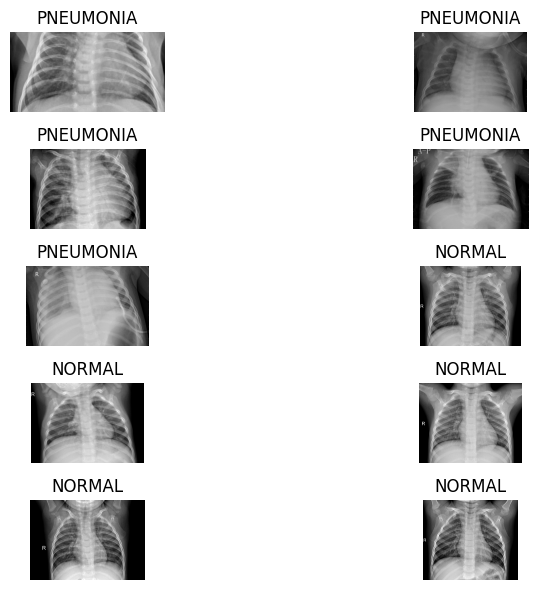

In [5]:
import matplotlib.pyplot as plt
import random
import os

# Charger quelques images aléatoires de chaque classe
nombre_echantillons = 5  # Vous pouvez choisir le nombre d'exemples à afficher

# Chemin vers le dossier d'entraînement des images
dossier_entrainement = 'Dataset/chest_xray/train'

# Liste des classes d'images
classes = ['PNEUMONIA', 'NORMAL']

# Créez une figure avec plusieurs sous-graphiques pour afficher les images
plt.figure(figsize=(10, 6))

for i, nom_classe in enumerate(classes):
    # Obtenez la liste des fichiers d'images de cette classe
    images_classe = os.listdir(os.path.join(dossier_entrainement, nom_classe))
    
    # Sélectionnez quelques échantillons aléatoires
    echantillons_aleatoires = random.sample(images_classe, nombre_echantillons)
    
    for j, nom_fichier_image in enumerate(echantillons_aleatoires):
        # Lire et afficher l'image
        chemin_image = os.path.join(dossier_entrainement, nom_classe, nom_fichier_image)
        image = plt.imread(chemin_image)
        
        plt.subplot(nombre_echantillons, len(classes), i * nombre_echantillons + j + 1)
        plt.imshow(image, cmap='gray')  # Utilisez la colormap 'gray' pour les images en niveaux de gris
        plt.title(nom_classe)
        plt.axis('off')

plt.tight_layout()
plt.show()


### 2- le nombre d'échantillons par classe

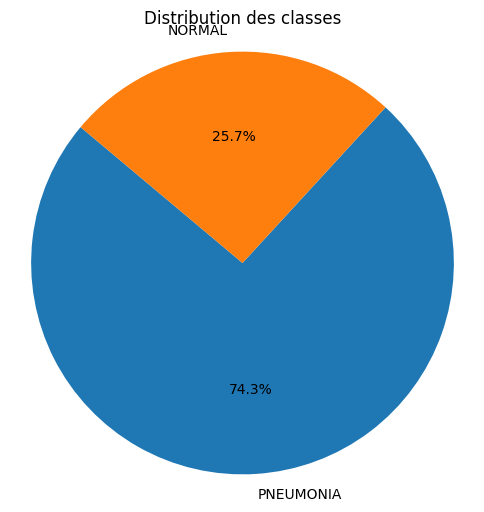

In [7]:
# Comptez le nombre d'échantillons par classe
num_samples_per_class = []
for class_name in classes:
    class_path = os.path.join(train_directory, class_name)
    num_samples = len(os.listdir(class_path))
    num_samples_per_class.append(num_samples)

# Affichez la distribution des classes
plt.figure(figsize=(6, 6))
plt.pie(num_samples_per_class, labels=classes, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des classes')
plt.axis('equal')  # Assurez-vous que le graphique soit un cercle

plt.show()


### 3- Les valeurs de pixel pour chaque classe 

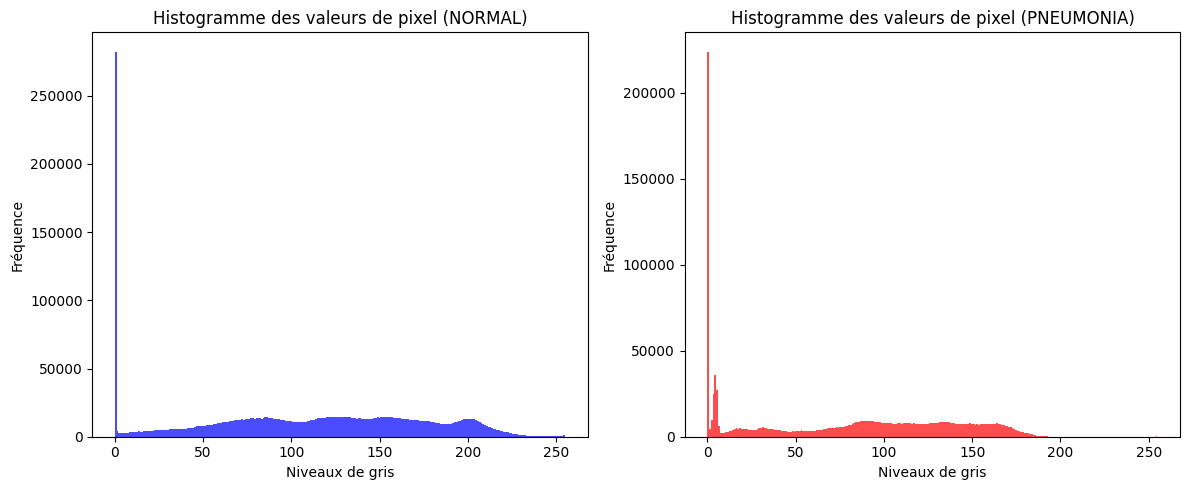

In [11]:
import matplotlib.pyplot as plt
import random

# Chemin du répertoire de train
train_directory = 'Dataset/chest_xray/train'
test_directory = 'Dataset/chest_xray/test'
val_directory = 'Dataset/chest_xray/val'

# Créez une liste des classes
classes = ['NORMAL', 'PNEUMONIA']


plt.figure(figsize=(12, 5))

for i, class_name in enumerate(classes):
    # Obtenez la liste des fichiers d'images de cette classe
    class_images = os.listdir(os.path.join(train_directory, class_name))
    
    # Sélectionnez un exemple d'image aléatoire
    random_image_filename = random.choice(class_images)
    
    # Lisez et affichez l'image
    image_path = os.path.join(train_directory, class_name, random_image_filename)
    img = plt.imread(image_path)
    
    plt.subplot(1, 2, i + 1)
    plt.hist(img.ravel(), bins=256, color='blue' if class_name == 'NORMAL' else 'red', alpha=0.7)
    plt.title(f'Histogramme des valeurs de pixel ({class_name})')
    plt.xlabel('Niveaux de gris')
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Définir les chemins vers les dossiers d'entraînement et de test
dossier_entrainement = 'Dataset/chest_xray/train'
dossier_test = 'Dataset/chest_xray/test'

# Créer des générateurs de données pour l'entraînement et le test
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalisation des valeurs de pixel
taille_lot = 32  # Taille du lot

train_generator = datagen.flow_from_directory(
    dossier_entrainement,
    target_size=(100, 100),  # Redimensionnez vos images à la taille d'entrée attendue par votre modèle
    batch_size=taille_lot,
    class_mode='binary'  # Pour une classification binaire (NORMAL, PNEUMONIA)
)

test_generator = datagen.flow_from_directory(
    dossier_test,
    target_size=(100, 100),
    batch_size=taille_lot,
    class_mode='binary'
)

# Créer un modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# Enregistrer le modèle
model.save("modele_de_base.h5")

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 137s 832ms/step - loss: 0.2225 - accuracy: 0.9118 - val_loss: 0.8479 - val_accuracy: 0.7244
Epoch 2/10
163/163 [==============================] - 133s 812ms/step - loss: 0.0893 - accuracy: 0.9670 - val_loss: 1.3384 - val_accuracy: 0.7228
Epoch 3/10
163/163 [==============================] - 138s 847ms/step - loss: 0.0878 - accuracy: 0.9663 - val_loss: 1.9082 - val_accuracy: 0.6731
Epoch 4/10
163/163 [==============================] - 132s 810ms/step - loss: 0.0739 - accuracy: 0.9739 - val_loss: 1.0374 - val_accuracy: 0.7484
Epoch 5/10
163/163 [==============================] - 135s 826ms/step - loss: 0.0538 - accuracy: 0.9804 - val_loss: 1.2659 - val_accuracy: 0.7612
Epoch 6/10
163/163 [==============================] - 231s 1s/step - loss: 0.0594 - accuracy: 0.9764 - val_loss: 0.8889 - val_accuracy: 0.7853
Epoch 7/10
163/163 [========================

/Users/stage2023/Desktop/Tp-python/Tp1/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 6s 305ms/step - loss: 2.1629 - accuracy: 0.7340
Test Loss: 2.1628997325897217
Test Accuracy: 0.7339743375778198


In [42]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Charger le modèle préalablement enregistré
loaded_model = tf.keras.models.load_model('modele_de_base.h5')

# Charger l'ensemble de données de test
dossier_test = 'Dataset1/test'
datagen = ImageDataGenerator(rescale=1.0/255.0)
taille_lot = 32

test_generator = datagen.flow_from_directory(
    dossier_test,
    target_size=(100, 100),
    batch_size=taille_lot,
    class_mode='binary'
)

# Prédictions sur l'ensemble de données de test
predictions = loaded_model.predict(test_generator, steps=len(test_generator))
predicted_classes = (predictions > 0.5).astype(int)  # Vous pouvez ajuster le seuil au besoin

# Obtenez les vraies étiquettes de test
true_labels = test_generator.labels

# Calculer la précision, le rappel et le F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_classes, average='binary')

# Imprimez les résultats
print(f"Précision (Accuracy) : {precision}")
print(f"Rappel : {recall}")
print(f"F1-score : {f1_score}")


Found 624 images belonging to 2 classes.
20/20 [==============================] - 6s 307ms/step
Précision (Accuracy) : 0.6304347826086957
Rappel : 0.8923076923076924
F1-score : 0.7388535031847134


## Class Imbalance

### Objective

Understand how class imbalance affects model performance and learn ways to mitigate it.

### Guidance

1. Train a baseline model without accounting for class imbalance.
2. Evaluate its performance using metrics like accuracy, precision, recall, and F1-score.
3. Experiment with techniques like class weighting or oversampling methods like SMOTE to balance the classes.

### Exercise

Address the class imbalance and evaluate the impact on the model. Write your code in the cell below.


## Model Building

### Objective

Build and train a deep learning model for image classification.

### Guidance

1. Use a Convolutional Neural Network (CNN) for this task.
2. Experiment with different architectures and hyperparameters.

### Exercise

Build and train your model. Write your code in the cell below.


##  Entrainer un modele sans prendre en consideration Le problème des données déséquilibrées

## Data Augmentation

### Objective

Improve your model's performance by using data augmentation techniques.

### Guidance

1. Apply data augmentation techniques like rotation, flipping, and zooming to generate more training data.
2. Retrain your model using the augmented dataset.

### Exercise

Apply data augmentation techniques and evaluate the impact on the model. Write your code in the cell below.


## Entrainer un modele avec des données équilibres à l'aide de la sous echantillonnage 

In [26]:
import os
import random

def sous_echantillonnage(path, pourcentage):
    
    files = os.listdir(path)
    
    
    nombre_a_supprimer = int(len(files) * pourcentage)
    
   
    random.shuffle(files)
    
   
    for i in range(nombre_a_supprimer):
        fichier_a_supprimer = os.path.join(path, files[i])
        os.remove(fichier_a_supprimer)


sous_echantillonnage('Dataset/chest_xray/train/PNEUMONIA', 0.1)



nouvelle_liste_fichiers = os.listdir('Dataset/chest_xray/train/PNEUMONIA')
nombre_fichiers_restants = len(nouvelle_liste_fichiers)
print(f"Nombre de fichiers restants : {nombre_fichiers_restants}")


Nombre de fichiers restants : 829


In [27]:
import os
from PIL import Image  # Importez la classe Image depuis le module PIL (Pillow)

def distribution(path):
    dossier_images = path
    extensions_images = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  

    # Compteur pour le nombre d'images
    nombre_images = 0

    for fichier in os.listdir(dossier_images):
        if os.path.isfile(os.path.join(dossier_images, fichier)):
            extension = os.path.splitext(fichier)[1].lower()
            if extension in extensions_images:
                try:
                    img = Image.open(os.path.join(dossier_images, fichier))
                    img.close()
                    nombre_images += 1
                except (IOError, OSError):
                    pass

    return nombre_images

imagenormale = distribution('Dataset/chest_xray/train/NORMAL')
image_PNEUMONIA = distribution('Dataset/chest_xray/train/PNEUMONIA')

print("Nombre d'images normales :", imagenormale)
print("Nombre d'images de PNEUMONIA :", image_PNEUMONIA)


Nombre d'images normales : 805
Nombre d'images de PNEUMONIA : 829


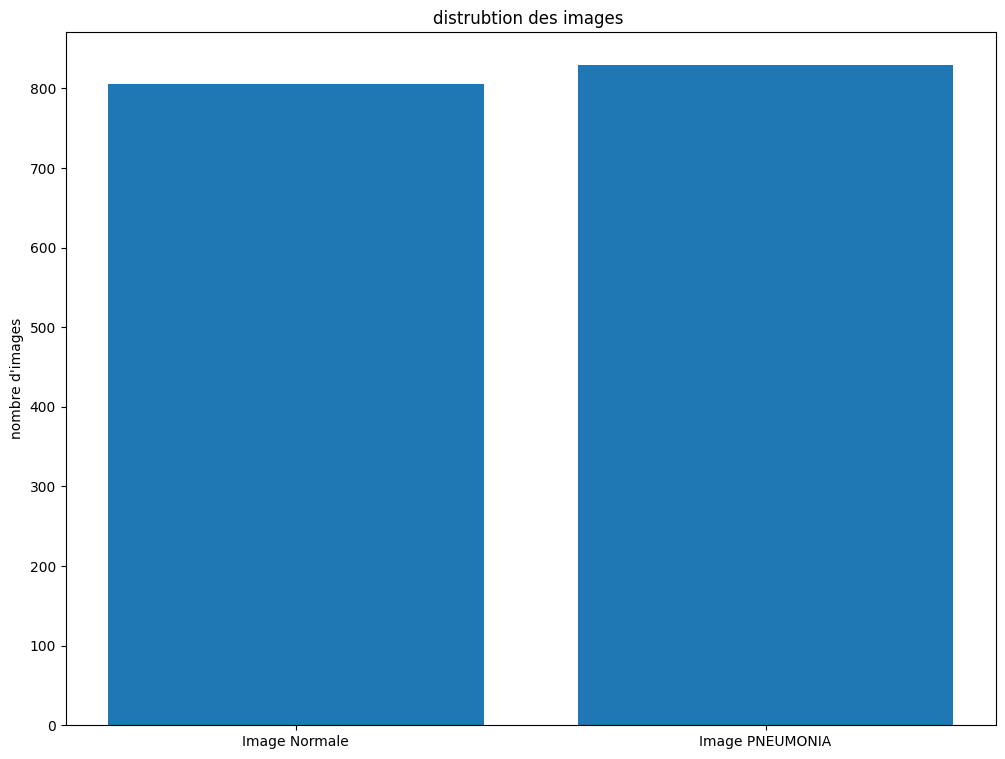

In [30]:
data={"Image Normale":imagenormale,"Image PNEUMONIA":image_PNEUMONIA}


fig,ax=plt.subplots(figsize=(12,9))
ax.bar(data.keys(),data.values());
ax.set(title="distrubtion des images ");
ax.set(ylabel="nombre d'images");


In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Définir les chemins vers les dossiers d'entraînement et de test
dossier_entrainement = 'Dataset/chest_xray/train'
dossier_test = 'Dataset/chest_xray/test'

# Créer des générateurs de données pour l'entraînement et le test
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalisation des valeurs de pixel
taille_lot = 32  # Taille du lot

train_generator = datagen.flow_from_directory(
    dossier_entrainement,
    target_size=(100, 100),  # Redimensionnez vos images à la taille d'entrée attendue par votre modèle
    batch_size=taille_lot,
    class_mode='binary'  # Pour une classification binaire (NORMAL, PNEUMONIA)
)

test_generator = datagen.flow_from_directory(
    dossier_test,
    target_size=(100, 100),
    batch_size=taille_lot,
    class_mode='binary'
)

# Créer un modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)
# Enregistrer le modèle sous le nom "sousechantillonnage_model.h5"
model.save("sousechantillonnage_model.h5")

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 1634 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
52/52 [==============================] - 35s 665ms/step - loss: 0.5187 - accuracy: 0.7509 - val_loss: 0.3489 - val_accuracy: 0.8429
Epoch 2/10
52/52 [==============================] - 34s 650ms/step - loss: 0.1739 - accuracy: 0.9394 - val_loss: 0.3107 - val_accuracy: 0.8702
Epoch 3/10
52/52 [==============================] - 35s 666ms/step - loss: 0.1095 - accuracy: 0.9608 - val_loss: 0.6678 - val_accuracy: 0.7660
Epoch 4/10
52/52 [==============================] - 35s 678ms/step - loss: 0.0965 - accuracy: 0.9633 - val_loss: 0.5311 - val_accuracy: 0.7981
Epoch 5/10
52/52 [==============================] - 35s 676ms/step - loss: 0.0891 - accuracy: 0.9670 - val_loss: 0.5822 - val_accuracy: 0.7901
Epoch 6/10
52/52 [==============================] - 35s 674ms/step - loss: 0.0710 - accuracy: 0.9767 - val_loss: 0.4922 - val_accuracy: 0.8333
Epoch 7/10
52/52 [==============================] - 35s 669

## calcule de la Précision, Rappel et F1-score 

In [41]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Charger le modèle préalablement enregistré
loaded_model = tf.keras.models.load_model('sousechantillonnage_model.h5')

# Charger l'ensemble de données de test
dossier_test = 'Dataset1/test'
datagen = ImageDataGenerator(rescale=1.0/255.0)
taille_lot = 32

test_generator = datagen.flow_from_directory(
    dossier_test,
    target_size=(100, 100),
    batch_size=taille_lot,
    class_mode='binary'
)

# Prédictions sur l'ensemble de données de test
predictions = loaded_model.predict(test_generator, steps=len(test_generator))
predicted_classes = (predictions > 0.5).astype(int)  # Vous pouvez ajuster le seuil au besoin

# Obtenez les vraies étiquettes de test
true_labels = test_generator.labels

# Calculer la précision, le rappel et le F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_classes, average='binary')

# Imprimez les résultats
print(f"Précision (Accuracy) : {precision}")
print(f"Rappel : {recall}")
print(f"F1-score : {f1_score}")


Found 624 images belonging to 2 classes.
20/20 [==============================] - 7s 319ms/step
Précision (Accuracy) : 0.6192384769539078
Rappel : 0.7923076923076923
F1-score : 0.6951631046119234


 ## Entrainer un modele avec des données équilibres à l'aide de oversimpling

In [36]:
import os
import shutil
import random

def oversampling(path, pourcentage, destination):
    files = os.listdir(path)
    
    # Calculer le nombre de fichiers à copier pour atteindre le pourcentage désiré
    nombre_a_copier = int(len(files) * pourcentage)
    
    if nombre_a_copier > len(files):
        raise ValueError("Le pourcentage spécifié dépasse le nombre total de fichiers.")
    
    # Sélectionner aléatoirement des fichiers à copier
    fichiers_a_copier = random.sample(files, nombre_a_copier)
    
    # Copier les fichiers sélectionnés dans le répertoire de destination
    for fichier in fichiers_a_copier:
        for _ in range(int(1/pourcentage)):
            shutil.copy(os.path.join(path, fichier), destination)

# Exemple d'utilisation pour augmenter de 100% le nombre d'échantillons en les copiant dans un répertoire de destination distinct
oversampling('Dataset1/train/PNEUMONIA', 1, 'Dataset1/train/oversampled_PNEUMONIA')

# Comptez le nombre total de fichiers après l'oversampling
nouvelle_liste_fichiers = os.listdir('Dataset1/train/oversampled_PNEUMONIA')
nombre_fichiers_apres_oversampling1 = len(nouvelle_liste_fichiers)
print(f"Nombre de fichiers après oversampling : {nombre_fichiers_apres_oversampling1}")
#image_PNEUMONIA = ('Dataset/chest_xray/train/PNEUMONIA')
#nombre_fichiers_apres_oversamplingPNO = len(image_PNEUMONIA)
#print("Nombre d'images de PNEUMONIA :", nombre_fichiers_apres_oversamplingPNO)


Nombre de fichiers après oversampling : 3875


In [33]:
import os
import shutil
import random

def oversampling(path, pourcentage, destination):
    files = os.listdir(path)
    
    # Calculer le nombre de fichiers à copier pour atteindre le pourcentage désiré
    nombre_a_copier = int(len(files) * pourcentage)
    
    if nombre_a_copier > len(files):
        raise ValueError("Le pourcentage spécifié dépasse le nombre total de fichiers.")
    
    # Sélectionner aléatoirement des fichiers à copier
    fichiers_a_copier = random.sample(files, nombre_a_copier)
    
    # Copier les fichiers sélectionnés dans le répertoire de destination
    for fichier in fichiers_a_copier:
        for _ in range(int(1/pourcentage)):
            shutil.copy(os.path.join(path, fichier), destination)

# Exemple d'utilisation pour augmenter de 100% le nombre d'échantillons en les copiant dans un répertoire de destination distinct
oversampling('Dataset1/train/NORMAL', 1, 'Dataset1/train/oversampled_NORMAL')

# Comptez le nombre total de fichiers après l'oversampling
nouvelle_liste_fichiers = os.listdir('Dataset1/train/oversampled_NORMAL')
nombre_fichiers_apres_oversampling = len(nouvelle_liste_fichiers)
print(f"Nombre de fichiers après oversampling : {nombre_fichiers_apres_oversampling}")
#image_PNEUMONIA = ('Dataset/chest_xray/train/PNEUMONIA')
#nombre_fichiers_apres_oversamplingPNO = len(image_PNEUMONIA)
#print("Nombre d'images de PNEUMONIA :", nombre_fichiers_apres_oversamplingPNO)


Nombre de fichiers après oversampling : 5217


In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Définir les chemins vers les dossiers d'entraînement et de test
dossier_entrainement = 'Dataset1/train'
dossier_test = 'Dataset1/test'

# Créer des générateurs de données pour l'entraînement et le test
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalisation des valeurs de pixel
taille_lot = 32  # Taille du lot

train_generator = datagen.flow_from_directory(
    dossier_entrainement,
    target_size=(100, 100),  # Redimensionnez vos images à la taille d'entrée attendue par votre modèle
    batch_size=taille_lot,
    class_mode='binary'  # Pour une classification binaire (NORMAL, PNEUMONIA)
)

test_generator = datagen.flow_from_directory(
    dossier_test,
    target_size=(100, 100),
    batch_size=taille_lot,
    class_mode='binary'
)

# Créer un modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)
# Enregistrer le modèle sous le nom "sousechantillonnage_model.h5"
model.save("Overechantillonnage_model.h5")

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 9833 images belonging to 4 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
308/308 [==============================] - 169s 546ms/step - loss: -112.7192 - accuracy: 0.0087 - val_loss: 13814.2246 - val_accuracy: 0.6250
Epoch 2/10
308/308 [==============================] - 177s 575ms/step - loss: -1565.1781 - accuracy: 0.0000e+00 - val_loss: 60191.1172 - val_accuracy: 0.6250
Epoch 3/10
308/308 [==============================] - 174s 565ms/step - loss: -13647.9590 - accuracy: 0.0000e+00 - val_loss: 275598.2188 - val_accuracy: 0.6250
Epoch 4/10
308/308 [==============================] - 171s 554ms/step - loss: -69230.8672 - accuracy: 0.0000e+00 - val_loss: 1142810.1250 - val_accuracy: 0.6250
Epoch 5/10
308/308 [==============================] - 216s 701ms/step - loss: -236530.0469 - accuracy: 0.0000e+00 - val_loss: 2205863.5000 - val_accuracy: 0.6250
Epoch 6/10
308/308 [==============================] - 169s 548ms/step - loss: -537529.9375 - accuracy: 0.0000e+00 - val_los

/Users/stage2023/Desktop/Tp-python/Tp1/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 6s 319ms/step - loss: 38263332.0000 - accuracy: 0.6250
Test Loss: 38263332.0
Test Accuracy: 0.625


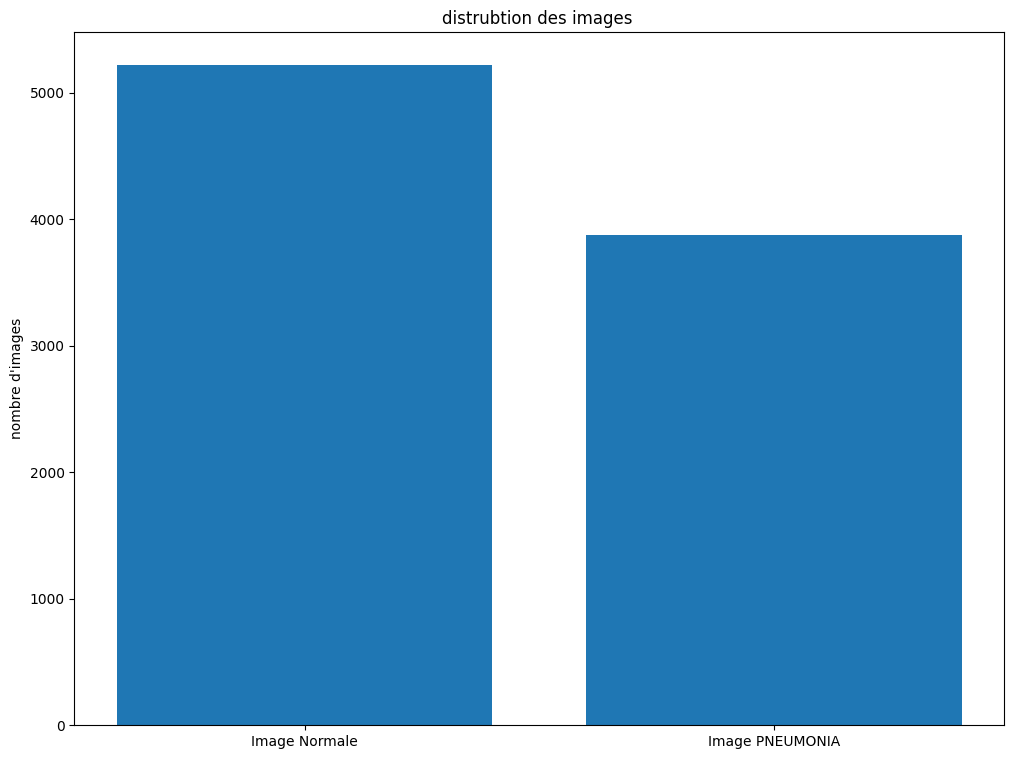

In [39]:
import matplotlib.pyplot as plt

data={"Image Normale":nombre_fichiers_apres_oversampling,"Image PNEUMONIA":nombre_fichiers_apres_oversampling1}


fig,ax=plt.subplots(figsize=(12,9))
ax.bar(data.keys(),data.values());
ax.set(title="distrubtion des images ");
ax.set(ylabel="nombre d'images");


## calcule de la Précision, Rappel et F1-score 

In [40]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Charger le modèle préalablement enregistré
loaded_model = tf.keras.models.load_model('Overechantillonnage_model.h5')

# Charger l'ensemble de données de test
dossier_test = 'Dataset1/test'
datagen = ImageDataGenerator(rescale=1.0/255.0)
taille_lot = 32

test_generator = datagen.flow_from_directory(
    dossier_test,
    target_size=(100, 100),
    batch_size=taille_lot,
    class_mode='binary'
)

# Prédictions sur l'ensemble de données de test
predictions = loaded_model.predict(test_generator, steps=len(test_generator))
predicted_classes = (predictions > 0.5).astype(int)  # Vous pouvez ajuster le seuil au besoin

# Obtenez les vraies étiquettes de test
true_labels = test_generator.labels

# Calculer la précision, le rappel et le F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_classes, average='binary')

# Imprimez les résultats
print(f"Précision (Accuracy) : {precision}")
print(f"Rappel : {recall}")
print(f"F1-score : {f1_score}")


Found 624 images belonging to 2 classes.
20/20 [==============================] - 9s 462ms/step
Précision (Accuracy) : 0.625
Rappel : 1.0
F1-score : 0.7692307692307693


## Model Deployment (Bonus)

### Objective

Learn the basics of deploying a machine learning model.

### Guidance

1. Save your trained model.
2. Use Flask to create a simple REST API to serve your model.

### Exercise

Deploy your model using Flask. Write your code in the cell below.
